<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/noise_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Variable noise GP algorithm

05/13/2024

* author `Boris Slautin`
* idea, supervision `Sergei Kalinin`
* gpax lib. `Maxim Ziatdinov`


In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax
!pip install --upgrade git+https://github.com/ziatdinovmax/atomai.git;

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/ziatdinovmax/atomai.git to /tmp/pip-req-build-fxj0t0c_
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/atomai.git /tmp/pip-req-build-fxj0t0c_
  Resolved https://github.com/ziatdinovmax/atomai.git to commit 3e4c005a31d7585a7fdfe5dfbd66f7fd726258ed
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cac

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict

import numpyro
import jax.numpy as jnp
import gpax
from gpax import MeasuredNoiseGP
from atomai import utils
from matplotlib.colors import LogNorm

gpax.utils.enable_x64()

In [3]:
#@title functions
np.random.seed(1)

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)*5

def variable_noise(t, a, b,):
  return a/np.sqrt(t)+b

def cost_funct(t, d, e):
  return e*t + d

def target_sharp(t, a, b, d, e):
  return (abs(cost_funct(t, d, e)**2 - variable_noise(t, a, b)**2))**0.5

def target_smooth(t, a, b, d, e):
  return ((cost_funct(t, d, e) - variable_noise(t, a, b))**2)

def target_smooth1(t, a, b, d, e):
  return 1/jnp.exp((cost_funct(t, d, e) - variable_noise(t, a, b))**2)

# Exact solution

In [4]:
from typing import Union, Dict, Callable, Optional, Type, Tuple
from jax import jit, vmap
import jax
import jaxlib
import jax.random as jra

import numpyro.distributions as dist

from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal

from gpax.models.linreg import LinReg

from gpax.utils import get_keys


In [5]:
def forester_function2D(x, t):
  return forrester_function(x)

def variable_noise2D(x, t, a, b,):
  return variable_noise(t, a, b)

def variable_noise2D_linearized(x, sqrt_t, a, b,):
  return a*sqrt_t + b

In [6]:
#@title modified kernels
def square_scaled_distance(X: jnp.ndarray, Z: jnp.ndarray,
                           lengthscale: Union[jnp.ndarray, float] = 1.
                           ) -> jnp.ndarray:
    r"""
    Computes a square of scaled distance, :math:`\|\frac{X-Z}{l}\|^2`,
    between X and Z are vectors with :math:`n x num_features` dimensions
    """
    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = jnp.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)

def add_jitter(x, jitter=1e-6):
    return x + jitter

def _sqrt(x, eps=1e-12):
    return jnp.sqrt(x + eps)


def MaternKernel_1dim(X: jnp.ndarray, Z: jnp.ndarray, params: Dict[str, jnp.ndarray], noise: int = 0, jitter: float = 1e-6, **kwargs) -> jnp.ndarray:

    r2 = square_scaled_distance(X[:,0:1], Z[:,0:1], params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = (1 + sqrt5_r + (5/3) * r2) * jnp.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += add_jitter(noise, jitter) * jnp.eye(X.shape[0])
    return k

def RBF_2nd_dim(X: jnp.ndarray, Z: jnp.ndarray, params: Dict[str, jnp.ndarray], noise: int = 0, jitter: float = 1e-6, **kwargs) -> jnp.ndarray:
    r2 = square_scaled_distance(X[:,1:2], Z[:,1:2], params["k_length"])
    k = params["k_scale"] * jnp.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += add_jitter(noise, jitter) * jnp.eye(X.shape[0])
    return k


#introducing custom Mettern-based kernel function
gpax.utils.set_kernel_fn(MaternKernel_1dim)
gpax.utils.set_kernel_fn(RBF_2nd_dim)

<PjitFunction of <function RBF_2nd_dim at 0x79c822865750>>

In [7]:
#@title viMeasuredNoiseGP
kernel_fn_type = Callable[[jnp.ndarray, jnp.ndarray, Dict[str, jnp.ndarray], jnp.ndarray], jnp.ndarray]

class viMeasuredNoiseGP(gpax.ExactGP):
  def __init__(self,
               input_dim: int,
               kernel: Union[str, kernel_fn_type],
               mean_fn: Optional[Callable[[jnp.ndarray, Dict[str, jnp.ndarray]], jnp.ndarray]] = None,
               kernel_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
               mean_fn_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
               lengthscale_prior_dist: Optional[dist.Distribution] = None,
               mean_fn_noise: Optional[Callable[[jnp.ndarray, Dict[str, jnp.ndarray]], jnp.ndarray]] = None,
               mean_fn_prior_noise: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
               guide: str = 'delta'
               ) -> None:
        args = (input_dim, kernel, mean_fn, kernel_prior, mean_fn_prior, None, None, lengthscale_prior_dist)
        super(viMeasuredNoiseGP, self).__init__(*args)
        self.measured_noise = None
        self.noise_predicted = None
        self.X_train = None
        self.y_train = None
        self.guide_type = AutoNormal if guide == 'normal' else AutoDelta
        self.svi = None

        self.mean_fn_noise = mean_fn_noise
        self.mean_fn_prior_noise = mean_fn_prior_noise

  def model(self, X: jnp.ndarray, y: jnp.ndarray = None, measured_noise: jnp.ndarray = None, **kwargs) -> None:
        """GP model that accepts measured noise"""
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])
        # Sample kernel parameters
        if self.kernel_prior:
            kernel_params = self.kernel_prior()
        else:
            kernel_params = self._sample_kernel_params()
        # Since we provide a measured noise, we don't infer it
        noise = numpyro.deterministic("noise", jnp.array(0.0))
        # Add mean function (if any)
        if self.mean_fn is not None:
            args = [X]
            if self.mean_fn_prior is not None:
                args += [self.mean_fn_prior()]
            f_loc += self.mean_fn(*args).squeeze()
        # compute kernel (with zero noise)
        k = self.kernel(X, X, kernel_params, 0, **kwargs)
        # Sample y according to the standard Gaussian process formula. Add measured noise to the covariance matrix
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k+jnp.diag(measured_noise)),
            obs=y,
        )

  def fit(self,
          rng_key: jnp.array,
          X: jnp.ndarray,
          y: jnp.ndarray,
          measured_noise: jnp.ndarray,
          num_steps: int = 1000,
          step_size: float = 5e-3,
          progress_bar: bool = True,
          print_summary: bool = True,
          device: Type[jaxlib.xla_extension.Device] = None,
          **kwargs: float
          ) -> None:

        X, y = self._set_data(X, y)
        if device:
            X = jax.device_put(X, device)
            y = jax.device_put(y, device)
        self.X_train = X
        self.y_train = y
        self.measured_noise = measured_noise

        optim = numpyro.optim.Adam(step_size=step_size, b1=0.5)
        self.svi = SVI(
            self.model,
            guide=self.guide_type(self.model),
            optim=optim,
            loss=Trace_ELBO(),
            **kwargs
        )

        self.kernel_params = self.svi.run(
            rng_key, num_steps, X, y, measured_noise, progress_bar=progress_bar)[0]

        if print_summary:
            self._print_summary()

  def get_samples(self) -> Dict[str, jnp.ndarray]:
        return self.svi.guide.median(self.kernel_params)

  def _print_summary(self) -> None:
        params_map = self.get_samples()
        print('\nInferred GP parameters')
        for (k, vals) in params_map.items():
            spaces = " " * (15 - len(k))
            print(k, spaces, jnp.around(vals, 4))

  def predict(self,
              rng_key: jnp.ndarray,
              X_new: jnp.ndarray,
              samples: Optional[Dict[str, jnp.ndarray]] = None,
              noiseless: bool = False,
              device: Type[jaxlib.xla_extension.Device] = None,
              noise_prediction_method: str = 'gpreg',
              noise_prediction_kernel = 'RBF',
              **kwargs: float
              ) -> Tuple[jnp.ndarray, jnp.ndarray]:

        if noise_prediction_method not in ["linreg", "gpreg"]:
          raise NotImplementedError(
              "For noise prediction method, select between 'linreg' and 'gpreg'")

        noise_pred_fn = self.linreg if noise_prediction_method == "linreg" else self.gpreg
        X_new = self._set_data(X_new)

        def sigma_sample(rng_key, K, X_new_shape):
            sig = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0))
            return sig * jra.normal(rng_key, X_new_shape[:1])

        if self.noise_predicted is not None:
            noise_predicted = self.noise_predicted
        else:
            print('----Noise model calculation----')
            kp, noise_predicted = noise_pred_fn(self.X_train, self.measured_noise, X_new, kernel = noise_prediction_kernel, **kwargs)
            self.noise_predicted = noise_predicted
            self.noise_kernel_params = kp
        if samples is None:
            samples = self.get_samples()
            samples['noise'] = jnp.array([0])
            self.samples = samples
        if device:
            self._set_training_data(device=device)
            X_new = jax.device_put(X_new, device)
            samples = jax.device_put(samples, device)


        mean, K = self.get_mvn_posterior(X_new, samples, noiseless, **kwargs)
        K += jnp.diag(noise_predicted)

        return mean, K.diagonal()

  def gpreg(self, x, y, x_new, kernel='RBF', **kwargs):
        keys = get_keys()
        vigp = gpax.viGP(self.kernel_dim,
                         kernel = kernel,
                         mean_fn= self.mean_fn_noise,
                         mean_fn_prior= self.mean_fn_prior_noise,
                         **kwargs)
        x_lin = x.copy()
        x_new_lin = x_new.copy()
        x_lin[:,1] =  1/np.sqrt(x[:,1])
        x_new_lin[:,1] = 1/np.sqrt(x_new[:,1])

        vigp.fit(keys[0], x_lin, y, num_steps=40000, step_size=1e-5, progress_bar=True, print_summary=True, **kwargs)

        mmean, unc = vigp.predict(keys[1], x_new_lin, noiseless=True)

        return vigp.get_samples(), mmean

  def linreg(self, x, y, x_new, kernel=None, **kwargs):
        #parameter kernel is unfunctional
        x_lin = x.copy()
        x_new_lin = x_new.copy()
        x_lin[:,1] =  1/np.sqrt(x[:,1])
        x_new_lin[:,1] = 1/np.sqrt(x_new[:,1])

        lreg = LinReg()
        lreg.train(x.reshape(-1, 2), y.reshape(-1, 1), **kwargs)
        res = lreg.predict(x_new)
        return lreg,


In [8]:
  #@title structured GP priors

  def mean_func_noise(coord: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return variable_noise2D(coord[:,0], coord[:,1], params['a'], params['b'],)

  def prior_noise():
    # Sample model parameters
    a = numpyro.sample("a", numpyro.distributions.HalfNormal(5))
    b = numpyro.sample("b", numpyro.distributions.HalfNormal(5))
    # Return sampled parameters as a dictionary
    return {'a': a, 'b': b}

  def mean_func_noise_linearized(coord: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return variable_noise2D_linearized(coord[:,0], coord[:,1], params['a'], params['b'],)


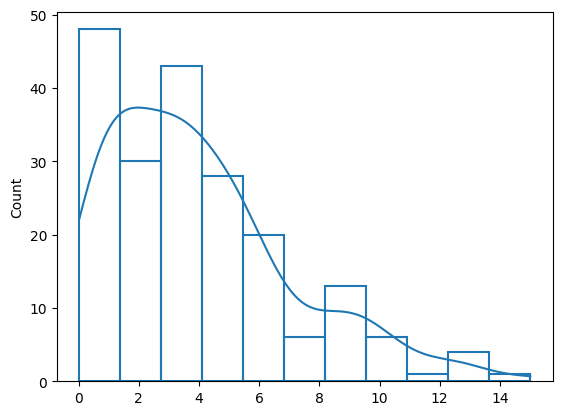

In [9]:
gpax.utils.dviz(dist.HalfNormal(5), samples=200)

In [10]:
#@title auxiliary functions


def plot_3d(func, var):
  if len(func.shape) == 1:
    s = int(np.sqrt(len(func)))
    func = func.reshape(s,s)
    var = var.reshape(s,s)

  # Plot the surface
  fig = plt.figure(figsize=(7, 3))
  ax1 = fig.add_subplot(121, projection='3d')
  ax1.plot_surface(X, T, func)

  # Set labels
  ax1.set_xlabel('x')
  ax1.set_ylabel('t')
  ax1.view_init(elev=30, azim=120)
  ax1.set_title('Function')

  ax2 = fig.add_subplot(122, projection='3d')
  ax2.plot_surface(X, T, var)

  # Set labels
  ax2.set_xlabel('x')
  ax2.set_ylabel('t')
  ax2.view_init(elev=30, azim=120)
  ax2.set_title('Noise')

  # Show plot
  return fig

Optimal measurement duration for a = 5 and b = 0.3: 3.02

------------------  Ground truth -------------------



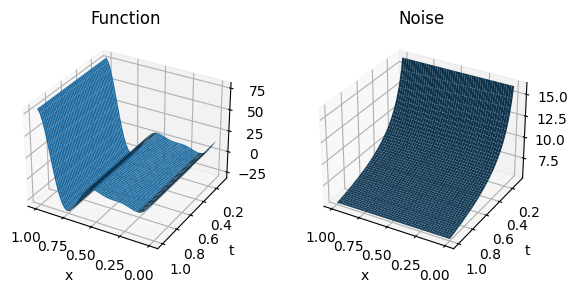


------------------ Iteration 0 -------------------



100%|██████████| 10000/10000 [00:10<00:00, 936.72it/s, init loss: 289.1012, avg. loss [9501-10000]: 274.0607]



Inferred GP parameters
k_length         [0.9004 0.0679]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:16<00:00, 2405.22it/s, init loss: 27.1134, avg. loss [38001-40000]: 13.1473]



Inferred GP parameters
k_length         [0.838  0.8928]
k_scale          1.127
noise            0.9115000000000001
a                3.6078
b                2.3969


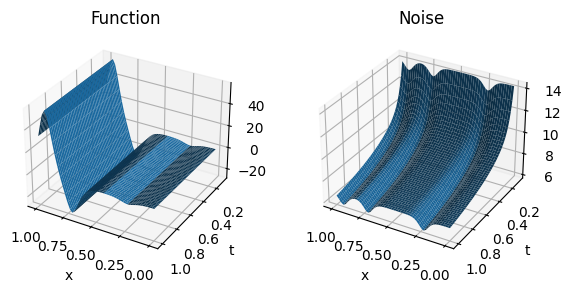

(x, t) =  [0.46938776 4.12244898]


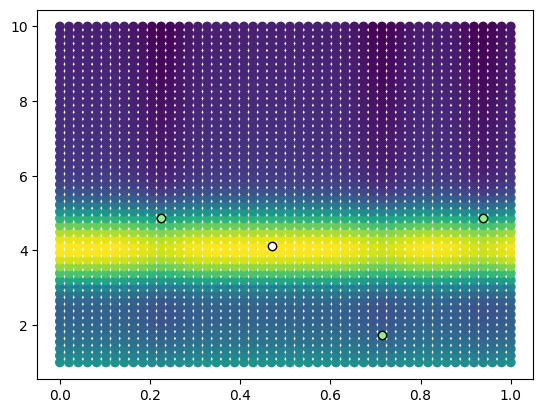


------------------ Iteration 1 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1756.50it/s, init loss: 293.2769, avg. loss [9501-10000]: 277.5203]



Inferred GP parameters
k_length         [0.9041 0.0663]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:14<00:00, 2796.31it/s, init loss: 40.6002, avg. loss [38001-40000]: 21.7229]



Inferred GP parameters
k_length         [0.9003 0.9642]
k_scale          1.3598000000000001
noise            1.2848000000000002
a                3.6065
b                2.3938


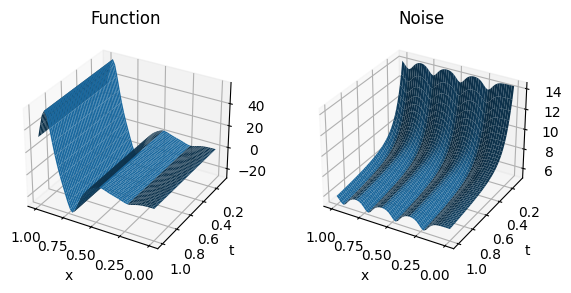

(x, t) =  [0.         4.12244898]


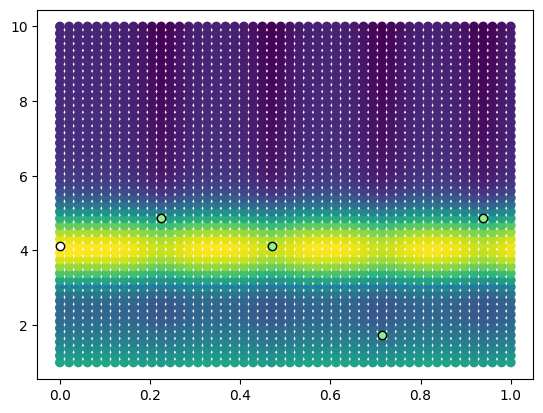


------------------ Iteration 2 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1869.91it/s, init loss: 343.0459, avg. loss [9501-10000]: 326.2028]



Inferred GP parameters
k_length         [0.9076 0.0647]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:13<00:00, 2949.71it/s, init loss: 53.9773, avg. loss [38001-40000]: 29.6713]



Inferred GP parameters
k_length         [0.8623 0.9365]
k_scale          1.5806
noise            1.2882
a                3.6045000000000003
b                2.3922000000000003


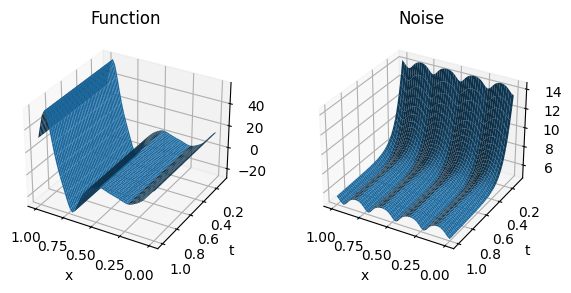

(x, t) =  [0.34693878 4.12244898]


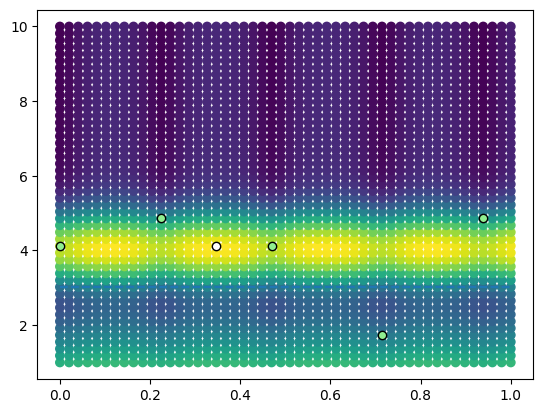


------------------ Iteration 3 -------------------



100%|██████████| 10000/10000 [00:04<00:00, 2113.49it/s, init loss: 345.0119, avg. loss [9501-10000]: 327.7534]



Inferred GP parameters
k_length         [0.9081 0.0644]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:14<00:00, 2721.30it/s, init loss: 60.9223, avg. loss [38001-40000]: 33.7054]



Inferred GP parameters
k_length         [0.8199 0.8957]
k_scale          1.5938
noise            1.2884
a                3.6018000000000003
b                2.3906


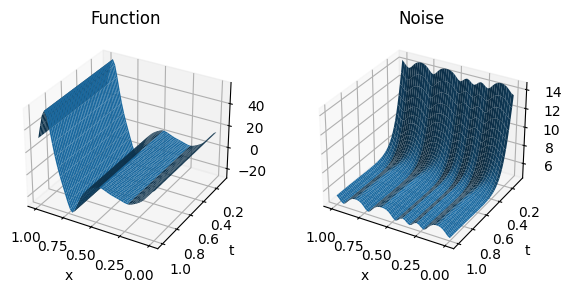

(x, t) =  [0.59183673 4.12244898]


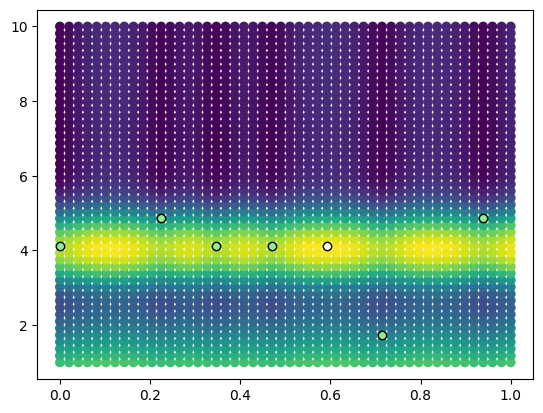


------------------ Iteration 4 -------------------



100%|██████████| 10000/10000 [00:04<00:00, 2037.06it/s, init loss: 346.6487, avg. loss [9501-10000]: 329.5144]



Inferred GP parameters
k_length         [0.9085 0.0632]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:14<00:00, 2719.36it/s, init loss: 64.5748, avg. loss [38001-40000]: 35.9620]



Inferred GP parameters
k_length         [0.7912 0.8822]
k_scale          1.5976000000000001
noise            1.2881
a                3.6006
b                2.3899


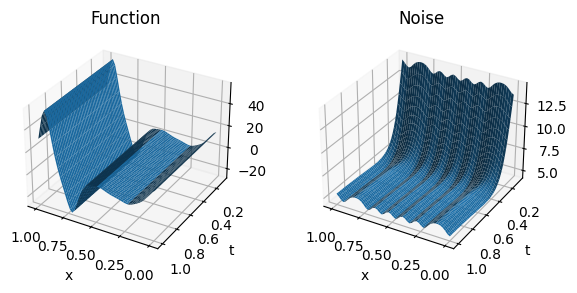

(x, t) =  [0.10204082 4.12244898]


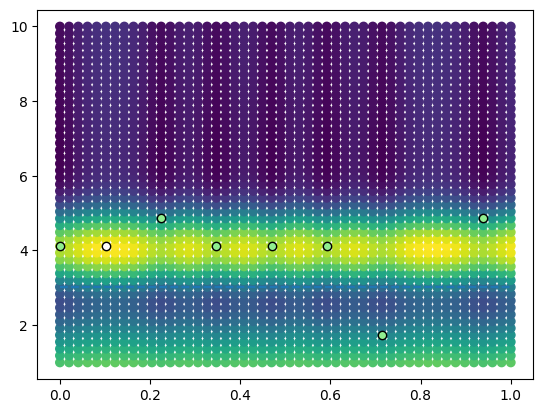


------------------ Iteration 5 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1491.33it/s, init loss: 357.4396, avg. loss [9501-10000]: 333.6649]



Inferred GP parameters
k_length         [0.929  0.0459]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:15<00:00, 2514.09it/s, init loss: 68.0779, avg. loss [38001-40000]: 38.2064]



Inferred GP parameters
k_length         [0.7622 0.8902]
k_scale          1.6001
noise            1.2879
a                3.5995000000000004
b                2.3893


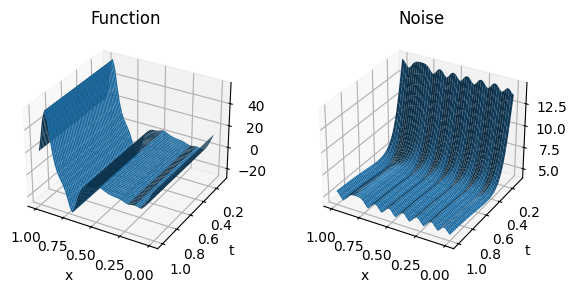

(x, t) =  [0.83673469 4.12244898]


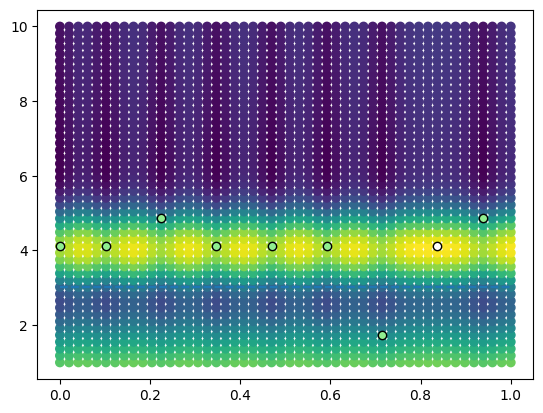


------------------ Iteration 6 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1434.13it/s, init loss: 389.6883, avg. loss [9501-10000]: 350.4447]



Inferred GP parameters
k_length         [0.9528 0.0321]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:17<00:00, 2301.64it/s, init loss: 70.5042, avg. loss [38001-40000]: 39.8859]



Inferred GP parameters
k_length         [0.7384 0.893 ]
k_scale          1.6015000000000001
noise            1.2875
a                3.5989
b                2.3890000000000002


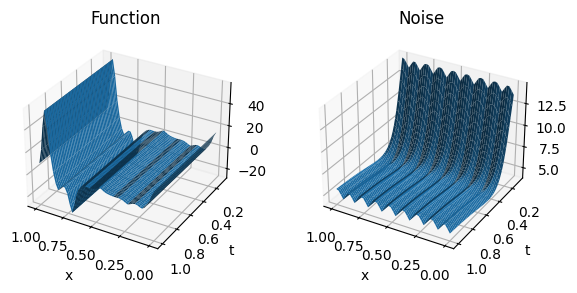

(x, t) =  [1.         4.12244898]


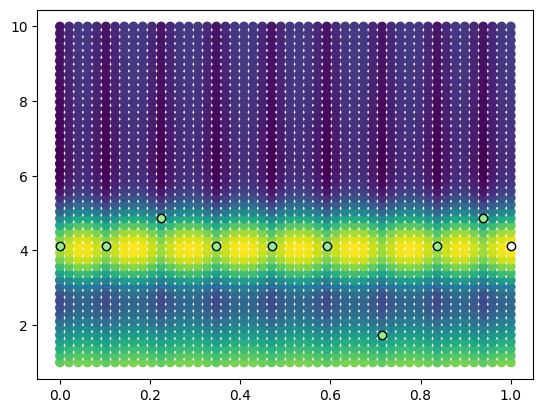


------------------ Iteration 7 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1625.15it/s, init loss: 1390.1463, avg. loss [9501-10000]: 1304.7585]



Inferred GP parameters
k_length         [1.1671 0.0851]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:17<00:00, 2293.74it/s, init loss: 74.0564, avg. loss [38001-40000]: 42.2936]



Inferred GP parameters
k_length         [0.7392 0.8953]
k_scale          1.6029
noise            1.2874
a                3.5984000000000003
b                2.3887


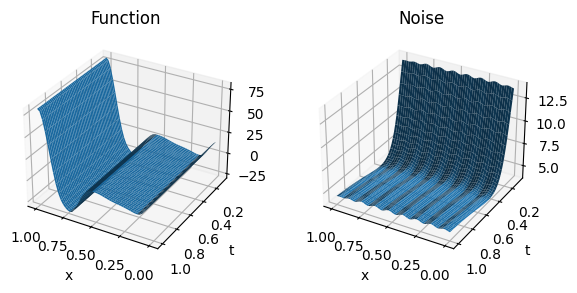

(x, t) =  [0.40816327 4.12244898]


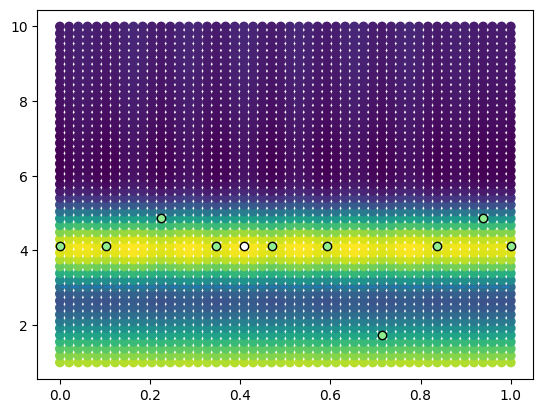


------------------ Iteration 8 -------------------



100%|██████████| 10000/10000 [00:07<00:00, 1427.29it/s, init loss: 1391.7567, avg. loss [9501-10000]: 1306.3800]



Inferred GP parameters
k_length         [1.1672 0.0852]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:19<00:00, 2019.90it/s, init loss: 75.2890, avg. loss [38001-40000]: 43.4807]



Inferred GP parameters
k_length         [0.7413 0.8959]
k_scale          1.6031
noise            1.2871000000000001
a                3.5983
b                2.3887


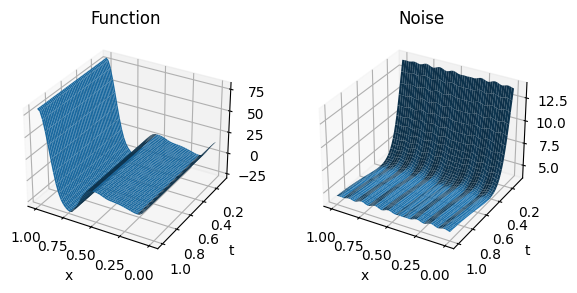

(x, t) =  [0.65306122 4.12244898]


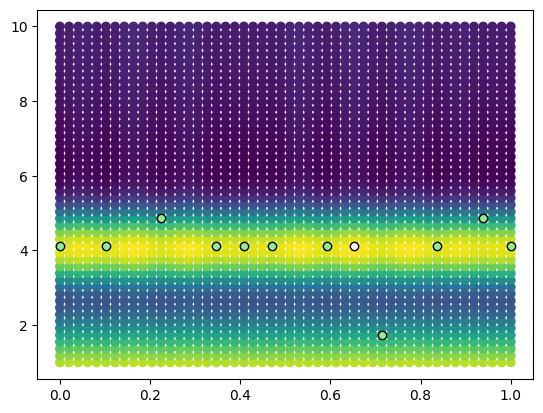


------------------ Iteration 9 -------------------



100%|██████████| 10000/10000 [00:05<00:00, 1786.29it/s, init loss: 1416.0122, avg. loss [9501-10000]: 1321.9516]



Inferred GP parameters
k_length         [1.1723 0.0859]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:18<00:00, 2198.00it/s, init loss: 76.8957, avg. loss [38001-40000]: 44.8555]



Inferred GP parameters
k_length         [0.7433 0.8967]
k_scale          1.6035000000000001
noise            1.2868000000000002
a                3.5982000000000003
b                2.3886000000000003


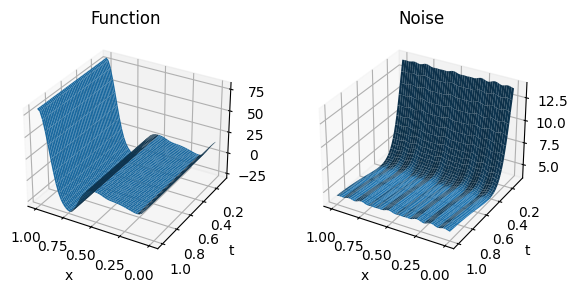

(x, t) =  [0.16326531 4.12244898]


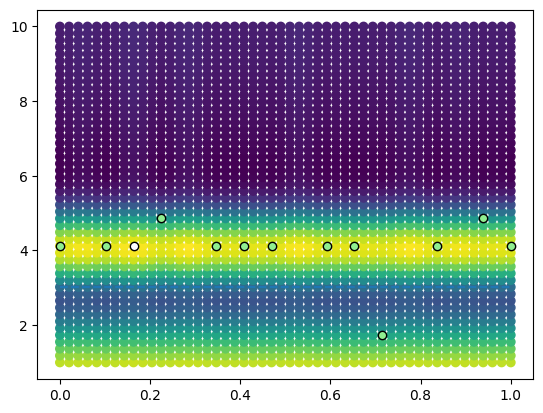


------------------ Iteration 10 -------------------



100%|██████████| 10000/10000 [00:07<00:00, 1267.82it/s, init loss: 1423.3938, avg. loss [9501-10000]: 1326.0575]



Inferred GP parameters
k_length         [1.1727 0.0854]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:19<00:00, 2057.39it/s, init loss: 77.9923, avg. loss [38001-40000]: 45.9913]



Inferred GP parameters
k_length         [0.7441 0.897 ]
k_scale          1.6036000000000001
noise            1.2864
a                3.5981
b                2.3886000000000003


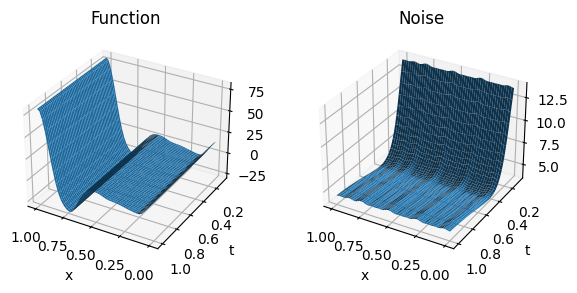

(x, t) =  [0.7755102  4.12244898]


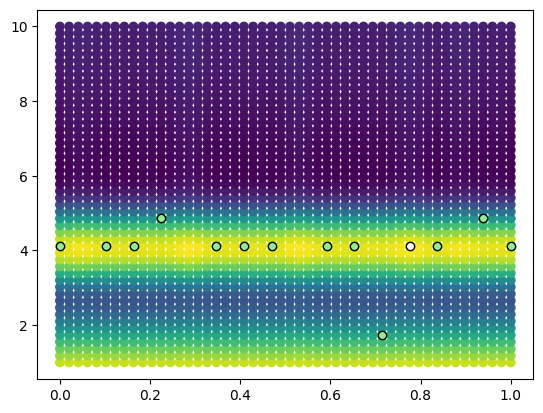


------------------ Iteration 11 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1577.34it/s, init loss: 1612.0092, avg. loss [9501-10000]: 1429.4133]



Inferred GP parameters
k_length         [1.196  0.0806]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:19<00:00, 2055.27it/s, init loss: 80.1359, avg. loss [38001-40000]: 47.6857]



Inferred GP parameters
k_length         [0.7456 0.8977]
k_scale          1.6041
noise            1.2861
a                3.5979
b                2.3884000000000003


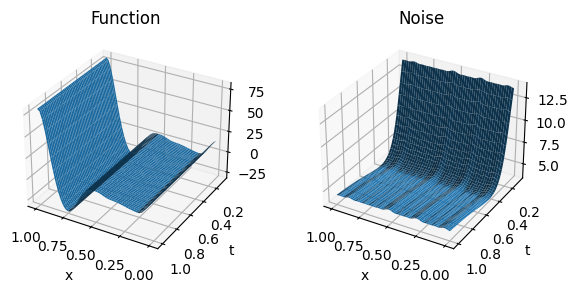

(x, t) =  [0.28571429 4.12244898]


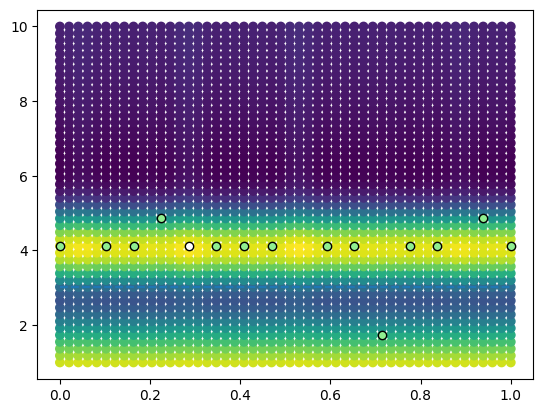


------------------ Iteration 12 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1575.32it/s, init loss: 1613.4073, avg. loss [9501-10000]: 1430.9030]



Inferred GP parameters
k_length         [1.196  0.0806]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:20<00:00, 1907.42it/s, init loss: 82.5683, avg. loss [38001-40000]: 49.5603]



Inferred GP parameters
k_length         [0.7468 0.8984]
k_scale          1.6046
noise            1.2859
a                3.5977
b                2.3883


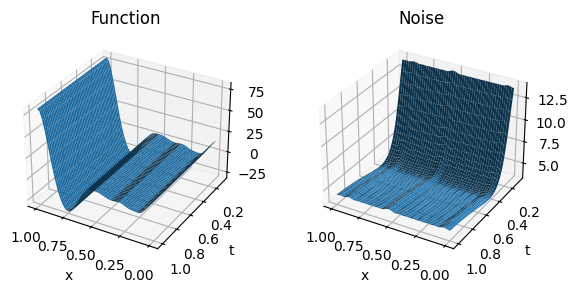

(x, t) =  [0.53061224 4.12244898]


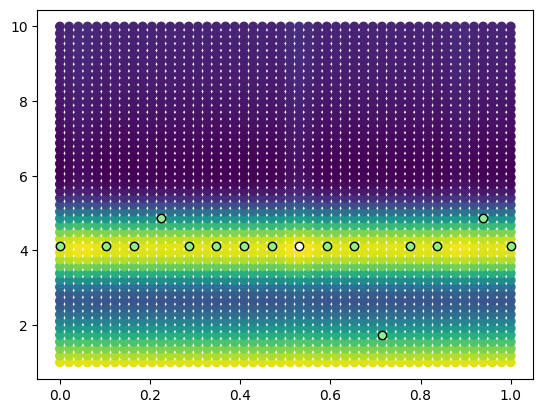


------------------ Iteration 13 -------------------



100%|██████████| 10000/10000 [00:06<00:00, 1443.03it/s, init loss: 1624.5898, avg. loss [9501-10000]: 1436.0300]



Inferred GP parameters
k_length         [1.1958 0.0802]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:20<00:00, 1991.99it/s, init loss: 83.8419, avg. loss [38001-40000]: 50.7885]



Inferred GP parameters
k_length         [0.7473 0.8987]
k_scale          1.6048
noise            1.2855
a                3.5976000000000004
b                2.3882000000000003


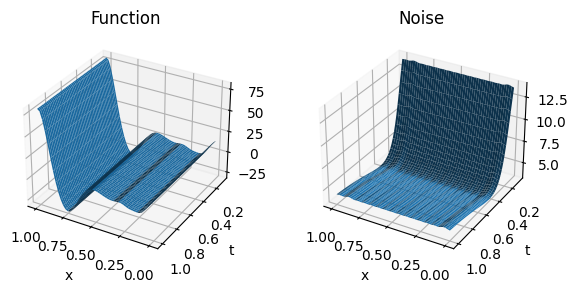

(x, t) =  [0.04081633 4.12244898]


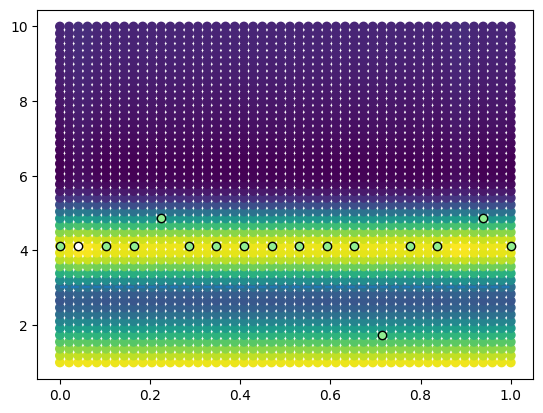


------------------ Iteration 14 -------------------



100%|██████████| 10000/10000 [00:19<00:00, 503.61it/s, init loss: 1626.4445, avg. loss [9501-10000]: 1437.7774]



Inferred GP parameters
k_length         [1.1963 0.0802]
k_scale          0.9825
noise            0.0
----Noise model calculation----


100%|██████████| 40000/40000 [00:20<00:00, 1914.49it/s, init loss: 84.7525, avg. loss [38001-40000]: 51.8635]



Inferred GP parameters
k_length         [0.7475 0.8988]
k_scale          1.6048
noise            1.2850000000000001
a                3.5976000000000004
b                2.3883


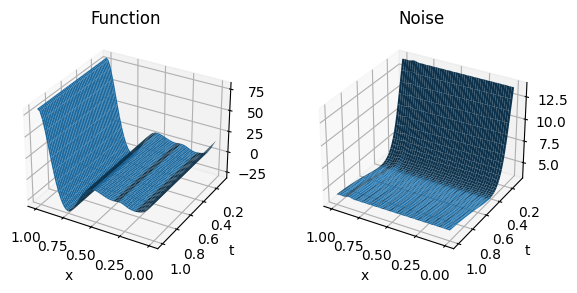

(x, t) =  [0.89795918 4.12244898]


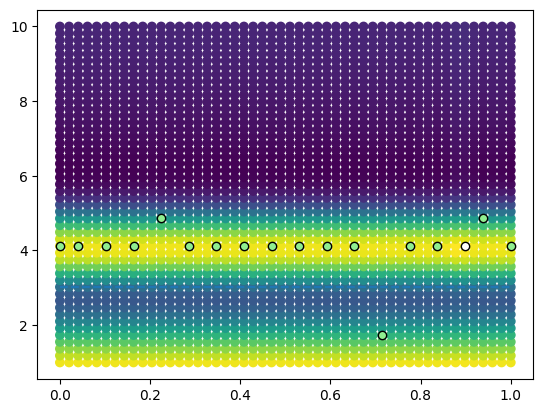

In [11]:
#noise models ground truth
a, b = 5, 0.3

#cost parameters
d, e = 0.5, 0.9

#Experiment params
num_measurements = 20         # Number of measurements per x
num_measurements_conv = 3     # Number of measurements per x after convergence
num_iteration = 15             # Number of exploration steps
num_seeds = 3               # Number of seed points

weighting_function = target_smooth1

#-----------------------------------------------------------------------------

# Limits, exploration field
x_all = np.linspace(0, 1, 50)
t_all = np.linspace(1, 10, 50)  # Start from 0.1 to avoid division by zero
X, T = np.meshgrid(x_all, t_all/10)

arg_opt_t = np.argmax(target_smooth1(t_all, a, b, d, e))
opt_t = t_all[arg_opt_t]
print(f'Optimal measurement duration for a = {a} and b = {b}: {round(opt_t,2)}')

coordinates = np.array([X.flatten(), T.flatten()]).T

#Ground truth
Y     = forester_function2D(X, T)
Noise = variable_noise2D(X, T, a, b)
print('\n------------------  Ground truth -------------------\n')
fig = plot_3d(Y, Noise)
plt.show()

#Seed measurements
c = np.random.choice(coordinates.shape[0], size=num_seeds, replace=True)
meas_c = coordinates[c] #seed coordinates

x = meas_c[:,0]
t = meas_c[:,1]
y_measurements = np.array([forrester_function(x[i]) +
                           np.random.normal(0, variable_noise(t[i], a, b),
                                            num_measurements) for i in range(len(x))]) #2d array (n_seeds, n_measurements)

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
y_noise = np.std(y_measurements, axis=1)

for iter in range(num_iteration):
  print(f'\n------------------ Iteration {iter} -------------------\n')
  #model initialization
  model = viMeasuredNoiseGP(input_dim=2,
                            kernel=MaternKernel_1dim, #custom kernel
                            guide='normal',
                            mean_fn_noise = mean_func_noise_linearized,
                            mean_fn_prior_noise = prior_noise
                            )


  key1, key2 = gpax.utils.get_keys(1)
  model.fit(key1, meas_c, y, y_noise, num_steps=10000)
  y_pred, y_var = model.predict(key2, coordinates, noise_prediction_kernel = RBF_2nd_dim)
  fig = plot_3d(y_pred, y_var)
  plt.show()

  acq = gpax.acquisition.UE(key1, model, coordinates, recent_points=meas_c)

  a_ = float(model.noise_kernel_params['a'])
  b_ = float(model.noise_kernel_params['b'])

  weights = weighting_function(coordinates[:,1]*10, a_, b_, d, e)

  acq_weighted =  (0.5*weights+0.5) * acq

  next_ind = np.argmax(acq_weighted)#np.random.choice(coordinates.shape[0], replace=True)
  next_c = coordinates[next_ind]
  print('(x, t) = ', next_c*np.array([1,10]))

  extent = [0.5, 10, 0, 1]
  plt.scatter(coordinates[:,0], coordinates[:,1]*10, c=acq_weighted,  norm=LogNorm())
  plt.scatter(meas_c[:,0], meas_c[:,1]*10, color='lightgreen', edgecolors='black')
  plt.scatter(next_c[0], next_c[1]*10, color='white', edgecolors='black')
  plt.hlines(opt_t, 0, 1, linestyle='dashed')
  plt.show()

  meas_c = np.vstack([meas_c, next_c])
  x = np.append(x, next_c[0])
  t = np.append(t, next_c[1])
  y_next = forrester_function(x[-1]) + np.random.normal(0, variable_noise(t[-1]*10, a, b), num_measurements)

  y = np.append(y, np.mean(y_next))
  y_noise = np.append(y_noise, np.std(y_next))





# Approximate solution

Text(0.5, 1.0, 'Ground truth')

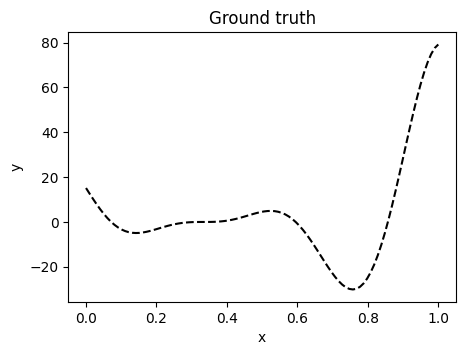

In [12]:
X = np.linspace(0,1,100)

_, ax = plt.subplots(figsize= (5,3.5), dpi=100)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(X, forrester_function(X), '--', color='black')
plt.title('Ground truth')

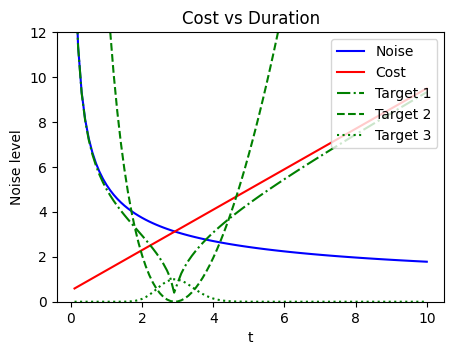

In [13]:
#visualise variable noise
a, b = 5, 0.2
d, e = 0.5, 0.9

dur = np.linspace(0.1, 10, 100)
noise = variable_noise(dur,a, b)
cost = cost_funct(dur, d, e)

_, ax = plt.subplots(figsize= (5,3.5), dpi=100)
ax.set_xlabel("t")
ax.set_ylabel("Noise level")
plt.plot(dur, noise, '-', color='b', label='Noise')
plt.plot(dur, cost,  '-', color='r', label='Cost')
plt.plot(dur, target_sharp(dur, a, b, d, e),  '-.', c='g', label='Target 1')
plt.plot(dur, target_smooth(dur, a, b, d, e), '--', c='g', label='Target 2')
plt.plot(dur, target_smooth1(dur, a, b, d, e), linestyle='dotted', c='g', label='Target 3')

plt.title('Cost vs Duration')
plt.ylim(0,12)
plt.legend(loc='upper right')

Target 3 was found to be an optimal choice for the noise sGP.

In [14]:
arg_opt_t = np.argmax(target_smooth1(dur, a, b, d, e))
opt_t = dur[arg_opt_t]
print(f'Optimal measurement duration for a = {a} and b = {b}: {round(opt_t,2)}')

Optimal measurement duration for a = 5 and b = 0.2: 2.9


In [15]:
#@title GP step functions
def NoiseGP_step(X, x, y, y_noise, ind_to_remove, verbose=True):
  if len(ind_to_remove) > 0:
    x_filt       = np.delete(x, ind_to_remove)
    y_filt       = np.delete(y, ind_to_remove)
    y_noise_filt = np.delete(y_noise, ind_to_remove)
  else:
    x_filt, y_filt, y_noise_filt = x.copy(), y.copy(), y_noise.copy()

  key1, key2 = gpax.utils.get_keys()
  model = gpax.MeasuredNoiseGP(1, "Matern")
  model.fit(key1, x_filt, y_filt, y_noise_filt)

  y_pred, y_sampled = model.predict(key2, X, noise_prediction_method='gpreg', n=100)

  acq = gpax.acquisition.UE(key2, model, X, noiseless=True)
  idx = acq.argmax()

  # Plot observed points, mean prediction, and acqusition function
  lower_b = y_pred - y_sampled.std(axis=(0,1))
  upper_b = y_pred + y_sampled.std(axis=(0,1))

  if verbose:
    # Plot results
    fig, axs = plt.subplots(2, 1, figsize=(7, 3), sharex=True)

    ax1 = axs[0]
    ax2 = axs[1]

    ax1.errorbar(x_filt, y_filt, yerr=np.sqrt(y_noise_filt), fmt='o', color='black', ecolor='red',
                alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
    if len(ind_to_remove) > 0:
      ax1.errorbar(x[ind_to_remove], y[ind_to_remove], yerr=np.sqrt(y_noise[ind_to_remove]),
                  fmt='o', color='black', ecolor='grey',
                  alpha=0.7, elinewidth=2, capsize=1, label='Excluded Observations', zorder=2)
    ax1.plot(X, y_pred, lw=1, c='b', label='Posterior mean')
    ax1.fill_between(
        X,
        lower_b,
        upper_b,
        color='blue',
        alpha=0.3,
        linewidth=0,
        label="Model uncertainty",)
    ax1.set_title('Exploring function')
    ax1.set_ylabel('y')


    ax2.plot(X, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(
        X[idx],
        acq[idx],
        s=30,
        marker="o",
        color="black",
        label='Next point to measure',
        zorder=3,)
    ax2.set_ylabel('UE acq.')

    plt.subplots_adjust(hspace=0.1)
    plt.xlabel('x')
    plt.legend()
    plt.show()

  return X[idx], (y_pred, y_sampled)


def sGP_step(dur, t, noise_targ, e, d, verbose=True):

  def mean_function(t: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return target_smooth1(t, params['a'], params['b'], d, e)

  def priors():
    # Sample model parameters
    a = numpyro.sample("a", numpyro.distributions.Uniform(0, 20))
    b = numpyro.sample("b", numpyro.distributions.Uniform(0, 1))
    # Return sampled parameters as a dictionary
    return {'a': a, 'b': b}

  key1, key2 = gpax.utils.get_keys()
  gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=mean_function, mean_fn_prior=priors)
  gp_model.fit(key1, t, noise_targ)

  t_pred, t_sampled = gp_model.predict(key2, dur, n=100)

  acq = gpax.acquisition.UCB(key2, gp_model, dur, noiseless=True, maximize=True, beta=10)
  idx = acq.argmax()

  if verbose:
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)

    ax[1].set_xlabel("$t$")
    ax[0].set_ylabel("Noise")
    ax[1].set_ylabel("UCB acq.")

    ax[0].scatter(t, noise_targ, marker='o', c='k', zorder=1, label="Noisy observations")

    lower_b = t_pred - t_sampled.std(axis=(0,1))
    upper_b = t_pred + t_sampled.std(axis=(0,1))

    ax[0].fill_between(
            dur,
            lower_b,
            upper_b,
            color='r',
            alpha=0.3,
            linewidth=0,
            label="Model uncertainty",)

    ax[0].plot(dur, t_pred, lw=1, zorder=1, c='r', label='Posterior mean')
    ax[0].set_title('Noise vs Duration')

    ax[1].plot(dur, acq, lw=2, c='orangered', label='Acquisition function')
    ax[1].scatter(
        dur[idx],
        acq[idx],
        s=30,
        marker="o",
        color="black",
        label='Next point to measure',
        zorder=3,)

    plt.subplots_adjust(hspace=0.1)
    plt.legend()

    plt.show()
  return dur[idx], (t_pred, t_sampled)


------------------ iter 0 -------------------



sample: 100%|██████████| 4000/4000 [00:03<00:00, 1012.20it/s, 3 steps of size 8.81e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.65      2.32      0.98      0.04      3.63   1253.29      1.00
    k_scale      1.37      1.61      0.89      0.06      2.94   1677.46      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



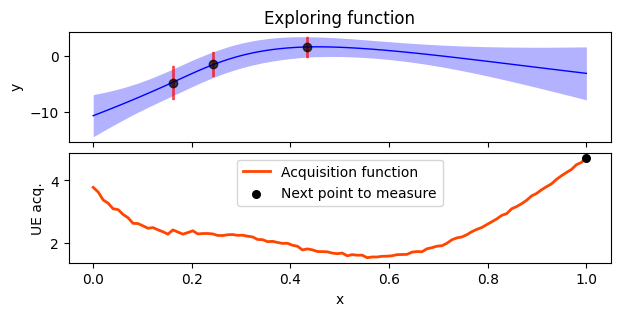

sample: 100%|██████████| 4000/4000 [00:05<00:00, 669.10it/s, 7 steps of size 3.95e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      9.95      5.78      9.84      1.73     19.65   1598.16      1.00
          b      0.50      0.29      0.49      0.05      0.94   1807.93      1.00
k_length[0]      3.44      2.69      2.90      0.05      6.46   1468.50      1.00
    k_scale     11.72      8.21     10.05      0.13     21.31   1136.36      1.00
      noise      3.45      6.11      1.18      0.04      9.07    415.10      1.00



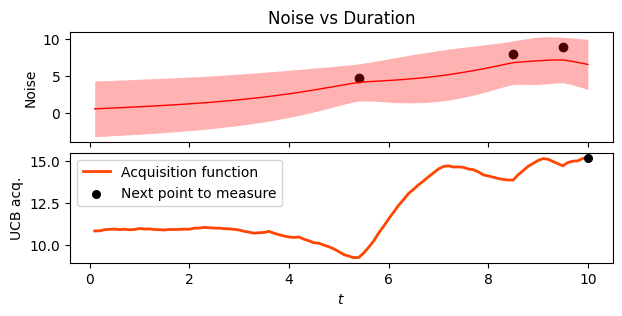


------------------ iter 1 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 720.86it/s, 7 steps of size 6.59e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.33      0.12      0.32      0.13      0.50   1105.76      1.00
    k_scale    482.00    184.54    444.79    223.66    727.95    809.68      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



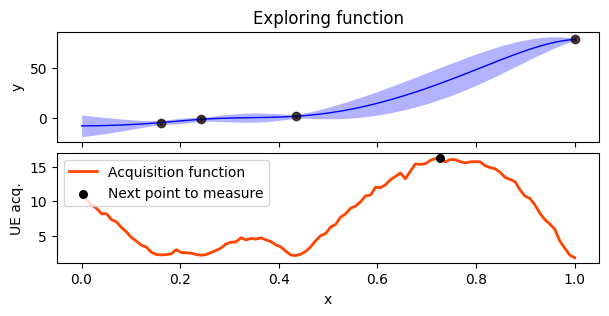

sample: 100%|██████████| 4000/4000 [00:07<00:00, 549.88it/s, 7 steps of size 2.99e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a     10.10      5.95      9.97      0.85     18.78    912.75      1.00
          b      0.49      0.29      0.48      0.04      0.94   1756.02      1.00
k_length[0]      2.16      2.94      1.33      0.08      4.78   1267.17      1.00
    k_scale      0.69      0.76      0.44      0.03      1.53   1199.69      1.00
      noise      0.49      0.52      0.33      0.03      1.06   1359.56      1.00



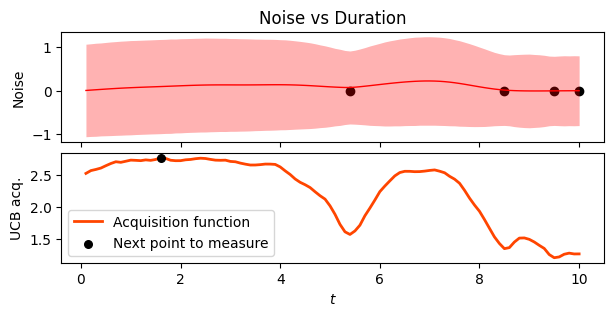


------------------ iter 2 -------------------



sample: 100%|██████████| 4000/4000 [00:06<00:00, 575.69it/s, 3 steps of size 7.41e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.13      0.05      0.12      0.05      0.20   1084.52      1.00
    k_scale    496.13    185.25    456.90    224.75    744.04    826.07      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



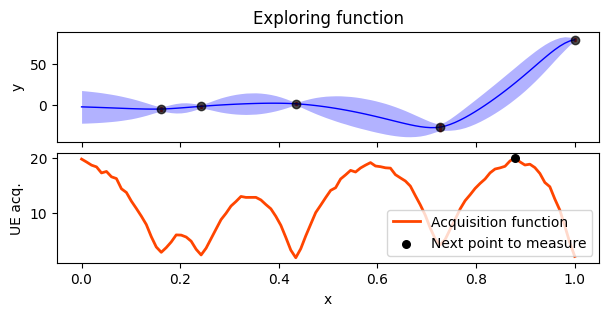

sample: 100%|██████████| 4000/4000 [00:06<00:00, 649.85it/s, 15 steps of size 3.46e-01. acc. prob=0.79] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      9.82      5.85      8.90      2.26     19.93    769.82      1.00
          b      0.49      0.29      0.50      0.06      0.94   1324.08      1.00
k_length[0]      2.31      3.40      1.32      0.03      5.26   1483.71      1.00
    k_scale      0.54      0.57      0.35      0.03      1.13    964.18      1.00
      noise      0.39      0.39      0.27      0.02      0.79   1078.00      1.00



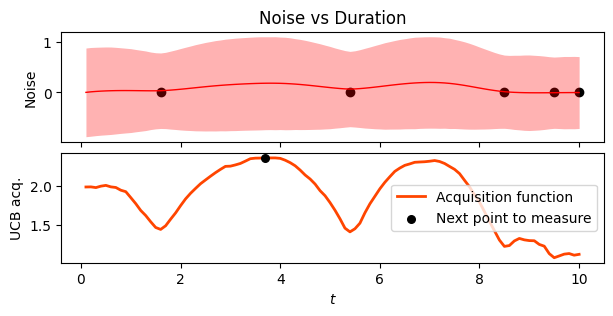


------------------ iter 3 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 830.38it/s, 7 steps of size 6.41e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.11      0.04      0.11      0.05      0.18    898.14      1.00
    k_scale    475.40    176.94    438.15    231.10    722.41    854.44      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



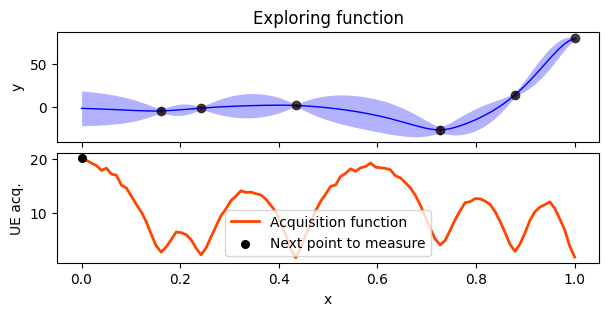

sample: 100%|██████████| 4000/4000 [00:05<00:00, 699.33it/s, 15 steps of size 1.98e-01. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      9.96      5.76      9.00      2.72     19.97    453.18      1.00
          b      0.49      0.29      0.47      0.06      0.94   1453.60      1.00
k_length[0]      2.33      3.33      1.34      0.02      5.27   1084.63      1.00
    k_scale      0.44      0.49      0.30      0.01      0.92   1147.88      1.00
      noise      0.33      0.31      0.23      0.01      0.67   1134.40      1.00



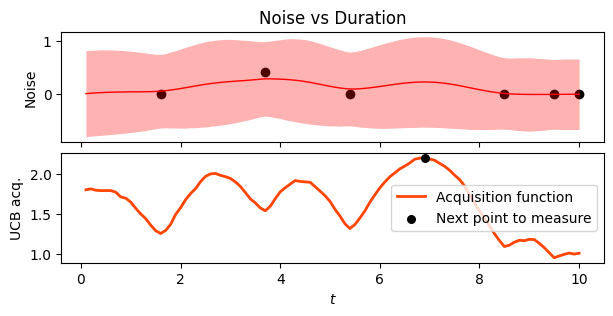


------------------ iter 4 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 865.48it/s, 7 steps of size 5.73e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.11      0.04      0.11      0.04      0.17   1104.83      1.00
    k_scale    465.08    172.74    432.66    212.90    696.20    893.55      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



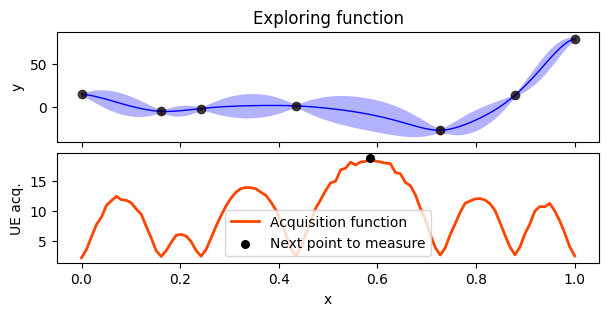

sample: 100%|██████████| 4000/4000 [00:06<00:00, 652.26it/s, 31 steps of size 1.56e-01. acc. prob=0.83] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      8.57      5.43      7.54      2.32     19.93    578.01      1.00
          b      0.48      0.29      0.47      0.00      0.90   1204.67      1.00
k_length[0]      2.73      3.90      1.58      0.04      5.99    854.57      1.00
    k_scale      0.39      0.38      0.27      0.02      0.79    931.70      1.00
      noise      0.26      0.25      0.19      0.02      0.53    818.14      1.00



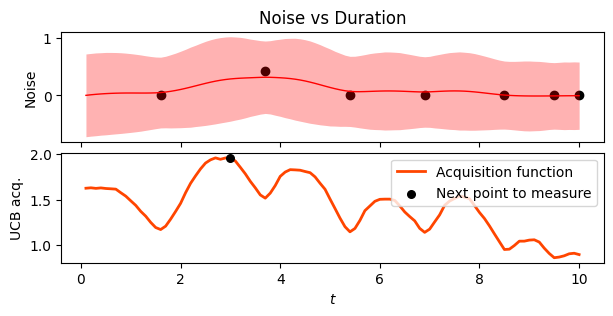


------------------ iter 5 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 771.46it/s, 7 steps of size 5.30e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.11      0.04      0.10      0.04      0.16   1037.09      1.00
    k_scale    447.16    160.72    417.85    207.56    662.96    816.33      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



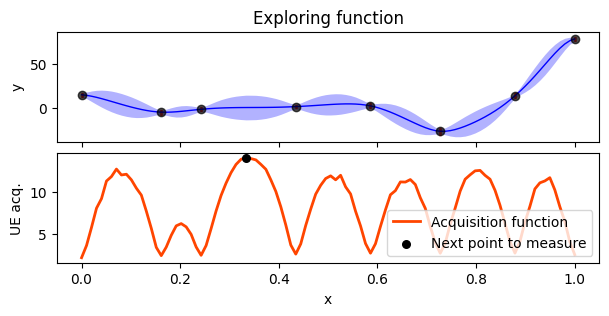

sample: 100%|██████████| 4000/4000 [00:06<00:00, 600.49it/s, 31 steps of size 1.46e-01. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      6.94      4.86      4.93      0.02     15.85    350.88      1.01
          b      0.50      0.28      0.50      0.03      0.91   1217.19      1.00
k_length[0]      3.22      4.44      1.71      0.05      7.48    682.95      1.00
    k_scale      0.39      0.41      0.25      0.01      0.83    646.10      1.00
      noise      0.23      0.23      0.16      0.01      0.49    526.34      1.00



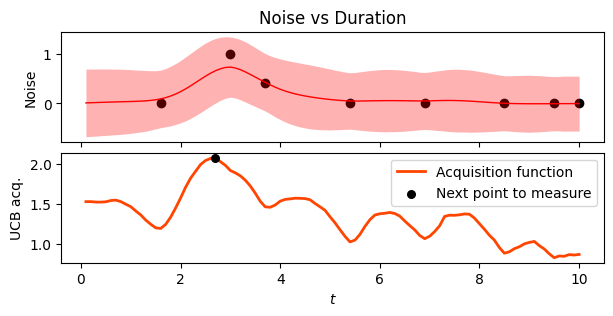


------------------ iter 6 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 802.36it/s, 7 steps of size 5.89e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.12      0.04      0.11      0.05      0.17    898.66      1.00
    k_scale    441.65    160.94    409.56    221.06    674.12    705.12      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



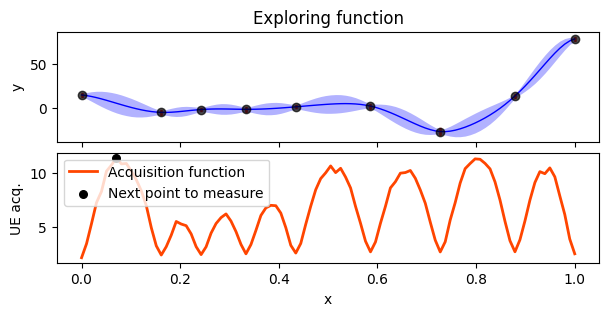

sample: 100%|██████████| 4000/4000 [00:08<00:00, 482.72it/s, 23 steps of size 1.16e-01. acc. prob=0.80] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      6.21      4.28      4.78      2.04     15.89    245.01      1.00
          b      0.49      0.29      0.49      0.02      0.90    445.71      1.00
k_length[0]      4.07      5.86      2.13      0.04      9.21    212.14      1.01
    k_scale      0.37      0.40      0.25      0.02      0.78    523.24      1.01
      noise      0.16      0.17      0.11      0.01      0.35    301.31      1.01



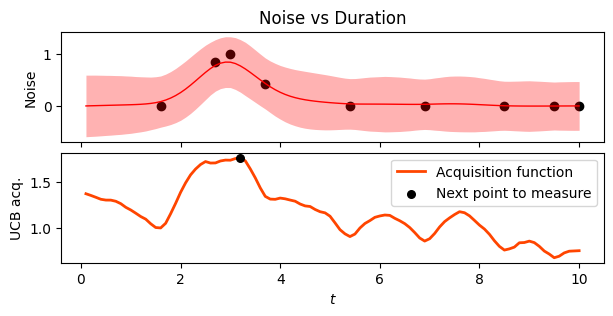


------------------ iter 7 -------------------



sample: 100%|██████████| 4000/4000 [00:06<00:00, 572.37it/s, 7 steps of size 4.80e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.12      0.04      0.12      0.06      0.18    723.25      1.00
    k_scale    444.91    161.54    414.16    203.06    674.04    737.14      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



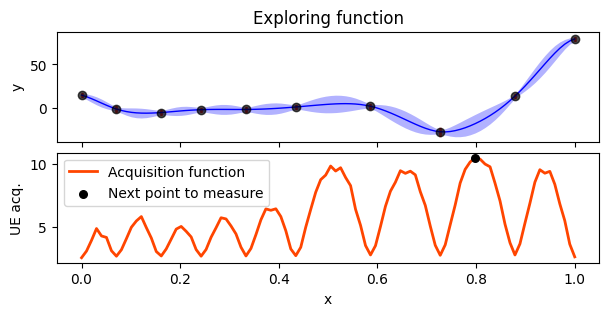

sample: 100%|██████████| 4000/4000 [00:08<00:00, 446.97it/s, 15 steps of size 2.18e-01. acc. prob=0.84] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      5.37      2.85      4.68      2.41      7.22    125.34      1.02
          b      0.49      0.29      0.49      0.03      0.92   1020.79      1.00
k_length[0]      4.99      6.12      3.07      0.04     10.91    478.20      1.00
    k_scale      0.36      0.46      0.22      0.01      0.77    715.99      1.00
      noise      0.10      0.10      0.07      0.01      0.22    383.89      1.02



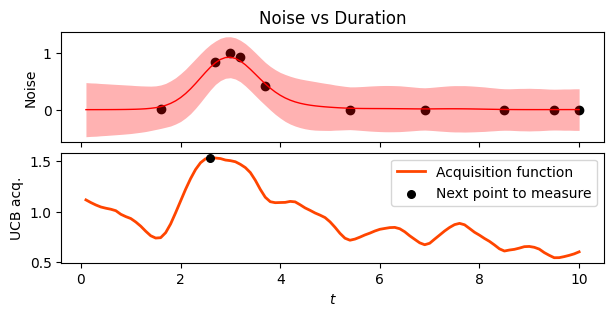


------------------ iter 8 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 773.96it/s, 7 steps of size 6.13e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.13      0.04      0.13      0.07      0.19    796.85      1.00
    k_scale    462.56    168.41    426.14    230.73    715.06    749.31      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



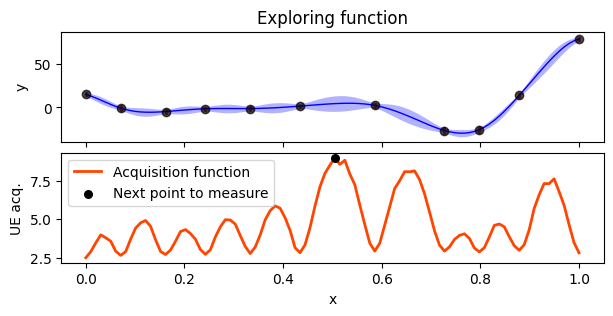

sample: 100%|██████████| 4000/4000 [00:08<00:00, 474.55it/s, 31 steps of size 8.02e-02. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      5.02      2.39      4.66      3.21      5.92    135.72      1.00
          b      0.50      0.29      0.50      0.09      0.97    951.39      1.00
k_length[0]      5.98      6.21      4.14      0.11     13.07    620.49      1.00
    k_scale      0.35      0.56      0.21      0.02      0.76    791.20      1.00
      noise      0.07      0.09      0.04      0.01      0.14    299.12      1.00



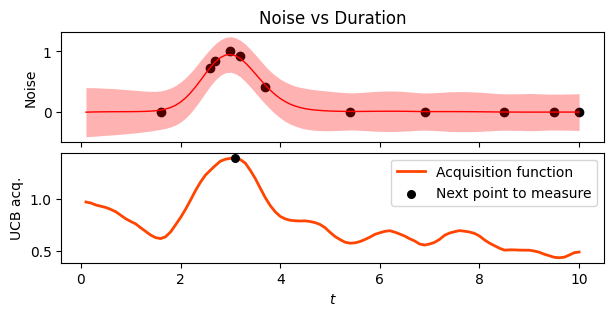


------------------ iter 9 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 721.53it/s, 7 steps of size 5.87e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.14      0.09      0.20    663.22      1.00
    k_scale    474.04    174.81    439.48    229.82    729.58    769.94      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



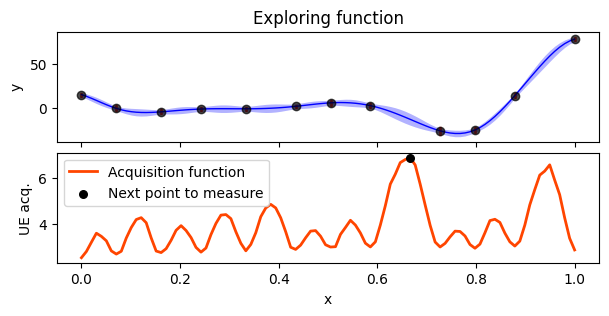

sample: 100%|██████████| 4000/4000 [00:08<00:00, 452.65it/s, 31 steps of size 1.26e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      5.01      2.27      4.67      3.60      5.75     46.21      1.02
          b      0.50      0.29      0.51      0.02      0.90    983.24      1.00
k_length[0]      7.80      9.26      5.36      0.07     16.38    518.85      1.00
    k_scale      0.32      0.37      0.20      0.00      0.72    912.64      1.00
      noise      0.04      0.05      0.02      0.00      0.09    207.16      1.00



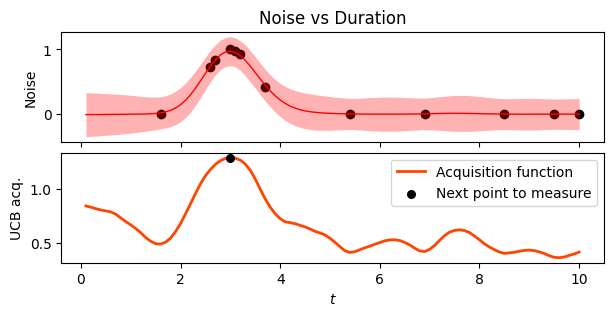


------------------ iter 10 -------------------



sample: 100%|██████████| 4000/4000 [00:08<00:00, 453.50it/s, 7 steps of size 5.64e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.14      0.09      0.20    722.25      1.00
    k_scale    467.68    173.65    434.39    213.67    704.61    690.26      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



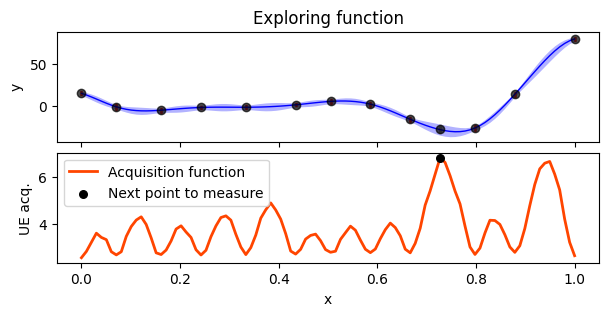

sample: 100%|██████████| 4000/4000 [00:07<00:00, 529.49it/s, 31 steps of size 1.32e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.69      0.60      4.72      3.85      5.56    545.37      1.00
          b      0.48      0.29      0.45      0.04      0.92    640.70      1.00
k_length[0]      9.69     12.18      7.15      0.16     19.32    876.36      1.00
    k_scale      0.32      0.40      0.19      0.01      0.71    559.49      1.00
      noise      0.02      0.03      0.01      0.00      0.05    595.15      1.00



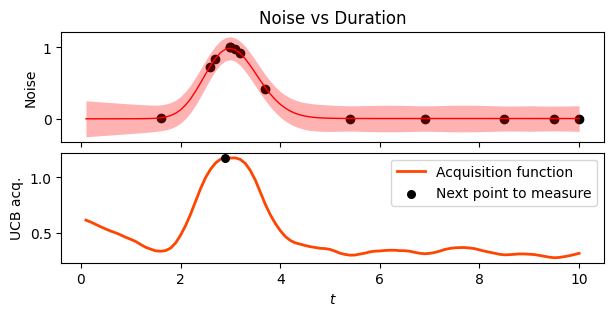


------------------ iter 11 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 682.58it/s, 7 steps of size 5.53e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.15      0.04      0.15      0.09      0.21    753.37      1.00
    k_scale    494.13    189.22    451.74    240.92    798.16    665.33      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



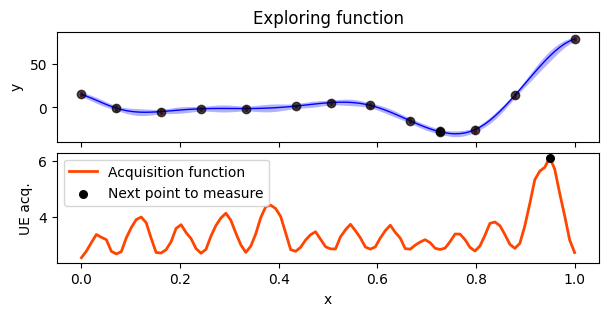

sample: 100%|██████████| 4000/4000 [00:11<00:00, 349.36it/s, 31 steps of size 1.05e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.65      0.75      4.67      3.89      5.52    143.72      1.01
          b      0.49      0.28      0.49      0.00      0.88    755.44      1.00
k_length[0]     10.66      9.23      8.48      0.26     20.39    906.95      1.00
    k_scale      0.34      0.44      0.21      0.01      0.76    994.96      1.01
      noise      0.01      0.02      0.01      0.00      0.03    383.26      1.00



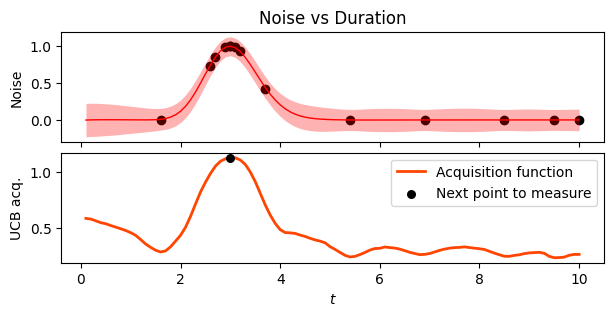


------------------ iter 12 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 710.13it/s, 7 steps of size 5.26e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.15      0.03      0.15      0.10      0.20    798.35      1.00
    k_scale    493.29    177.55    457.11    243.36    757.67    750.92      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



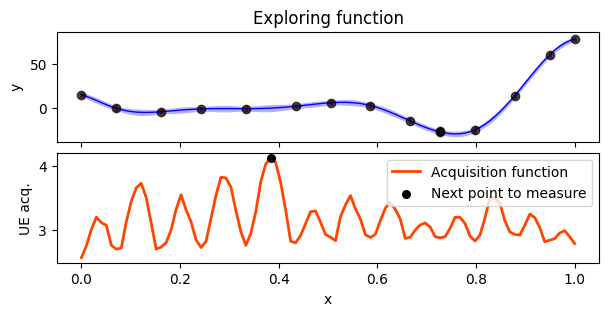

Noise GP already converged. Optimal duration: 3.0

------------------ iter 13 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 763.35it/s, 7 steps of size 5.35e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.16      0.03      0.15      0.11      0.21    764.35      1.00
    k_scale    494.94    174.74    461.23    236.42    746.35    781.39      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



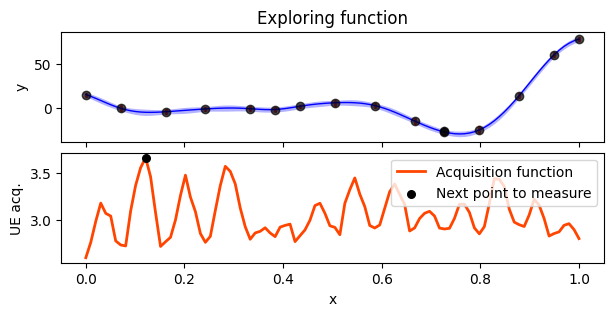

Noise GP already converged. Optimal duration: 2.98

------------------ iter 14 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 701.66it/s, 7 steps of size 4.70e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.16      0.03      0.16      0.11      0.21    917.77      1.00
    k_scale    499.72    187.68    463.69    227.09    760.01    816.38      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



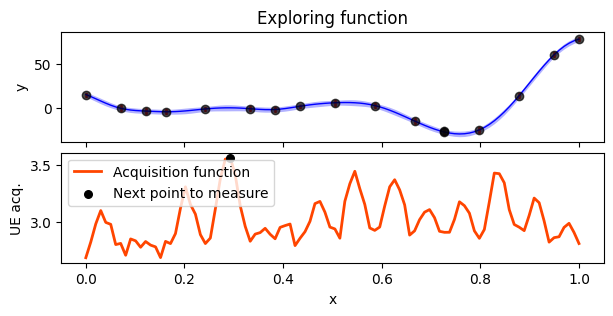

Noise GP already converged. Optimal duration: 2.97

------------------ iter 15 -------------------



sample: 100%|██████████| 4000/4000 [00:06<00:00, 588.73it/s, 7 steps of size 5.13e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.16      0.03      0.16      0.11      0.21    686.09      1.00
    k_scale    496.01    180.30    458.77    237.91    760.54    733.81      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



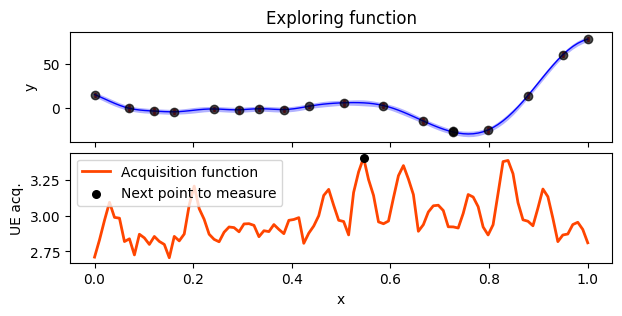

Noise GP already converged. Optimal duration: 2.99


In [16]:
#ground truth noise params
a = 5
b = 0.3

#known cost params
d = 0.5
e = 0.9

#Experiment params
num_measurements = 20  # Number of measurements per x
num_measurements_conv = 3  # Number of measurements per x after convergence
num_iteration = 16      # Number of exploration steps
num_seeds = 3          # Number of seed points

#params for duration convergence
conv_tail = 4          #the length of tail to assess convergence of noise GP
var_tresh = 0.1        #t variation threshold

#params to filter points
x_dist_thresh = 0.1
noise_ratio_thresh = 2

X = np.linspace(0,1,100)
dur = np.linspace(0.1, 10, 100)

#effective cost function
cost = cost_funct(dur, d, e)

#seeds
x = np.random.choice(X, size=num_seeds, replace=True)
t = np.random.choice(dur, size=num_seeds, replace=False)
y_measurements = np.array([forrester_function(x[i]) + np.random.normal(0, variable_noise(t[i], a, b), num_measurements) for i in range(len(x))])

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
y_noise = np.var(y_measurements, axis=1)

noise_targ = target_sharp(t, a, b, d, e)
ind_to_remove = np.array([])

for iter in range(num_iteration):
  print(f'\n------------------ iter {iter} -------------------\n')
  #an exclusion of the noisy points if we measure nearby with much higher precision
  dists = abs(x - x[-1])
  new_inds = np.where((dists < x_dist_thresh) & (y_noise > noise_ratio_thresh*y_noise[-1]))[0]
  ind_to_remove = np.unique(np.append(ind_to_remove, new_inds)).astype(int)

  next_x, (y_pred, y_sampled) = NoiseGP_step(X, x, y, y_noise, ind_to_remove, verbose=True)
  if np.std(t[-conv_tail:]) > var_tresh:
    next_t, (t_pred, t_sampled) = sGP_step(dur, t, noise_targ, e, d, verbose=True)
    next_y_meas = np.array([forrester_function(next_x) + np.random.normal(0, variable_noise(next_t, a, b), num_measurements)])
    y = np.append(y, np.mean(next_y_meas, axis=1))
    y_noise = np.append(y_noise, np.var(next_y_meas, axis=1))
  else:
    next_t = np.mean(t[-conv_tail:])
    next_y_meas = np.array([forrester_function(next_x) + np.random.normal(0, variable_noise(next_t, a, b), num_measurements_conv)])
    y = np.append(y, np.mean(next_y_meas))
    y_noise = np.append(y_noise, np.mean(y_noise[-conv_tail:]))
    print(f'Noise GP already converged. Optimal duration: {round(next_t,2)}')

  t = np.append(t, next_t)
  x = np.append(x, next_x)


  noise_targ = target_smooth1(t, a, b, d, e)

In [17]:
key1, key2 = gpax.utils.get_keys()
model = gpax.MeasuredNoiseGP(1, "Matern")
model.fit(key1, x, y, y_noise)

y_pred, y_sampled = model.predict(key2, X, noise_prediction_method='gpreg', n=100)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 642.07it/s, 3 steps of size 5.89e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.16      0.03      0.16      0.11      0.21    736.40      1.00
    k_scale    501.24    183.41    467.23    236.32    762.10    733.98      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



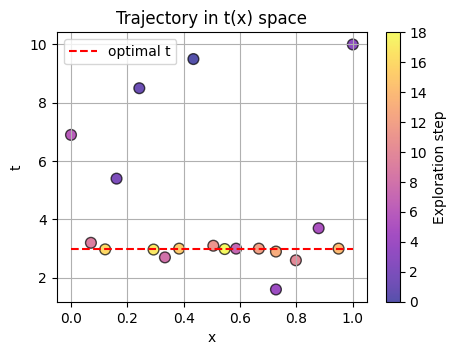

In [18]:
arg_opt_t = np.argmax(target_smooth1(dur, a, b, d, e))
opt_t = dur[arg_opt_t]

fig, ax = plt.subplots(figsize=(5, 3.5))

sc=plt.scatter(x,
              t,
              s=60,
              cmap='plasma',
              c = np.arange(len(x)),
              edgecolor='black',
              alpha=0.7)

cbar_sc = fig.colorbar(sc, ax=ax, label="Exploration step")

plt.hlines(opt_t, 0, 1, linestyles='--', color='red', label='optimal t')

plt.title('Trajectory in t(x) space')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.grid()